In [1]:
%cd src/
from pathlib import Path
import numpy as np
import math
from itertools import groupby
import h5py
import numpy as np
import unicodedata
import cv2
import torch
from torch import nn
from torchvision.models import resnet50, resnet101, resnet34
from torch.autograd import Variable
import torchvision
from data import preproc as pp
from data import evaluation
from torch.utils.data import Dataset
import time
import timm



class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=128):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class OCR(nn.Module):

    def __init__(self, vocab_len, hidden_dim, nheads,
                 num_encoder_layers, num_decoder_layers):
        super().__init__()
    
#         self.backbone = timm.create_model('ecaresnet101d', pretrained=True,)
#         del self.backbone.fc
#         self.backbone = resnet101(pretrained=True)
        self.backbone = timm.create_model('resnest101e', pretrained=True)
    
        del self.backbone.fc
        
        
#         del self.backbone.classifier, self.backbone.conv_head, self.backbone.bn2,self.backbone.act2,self.backbone.global_pool
        _ = self.backbone.to("cpu")
#         for name,p in self.backbone.named_parameters():
#             if "bn" not in name or "attnpool" in name:
#                 p.requires_grad =  False

        # create a default PyTorch transformer
        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads with length of vocab
        # DETR used basic 3 layer MLP for output
        self.vocab = nn.Linear(hidden_dim,vocab_len)

        # output positional encodings (object queries)
        self.decoder = nn.Embedding(vocab_len, hidden_dim)
        self.query_pos = PositionalEncoding(hidden_dim, .2)

        # spatial positional encodings, sine positional encoding can be used.
        # Detr baseline uses sine positional encoding.
        self.row_embed = nn.Parameter(torch.rand(90, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(90, hidden_dim // 2))
        self.trg_mask = None
  
    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), 1)
        mask = mask.masked_fill(mask==1, float('-inf'))
        return mask
    
#     def get_feature(self,x):
#             x = self.backbone.conv_stem(x)
#             x = self.backbone.bn1(x)   
#             x = self.backbone.act1(x)
#             x = self.backbone.blocks(x)
#             return x

    def get_feature(self,x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)   
#         x = self.backbone.relu(x)
#         x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        return x

#     def get_feature(self, x):
#         x = self.backbone.forward_features(x)
#         return x


    def make_len_mask(self, inp):
        return (inp == 0).transpose(0, 1)


    def forward(self, inputs, trg):
        # propagate inputs through ResNet-101 up to avg-pool layer
        x = self.get_feature(inputs)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        bs,_,H, W = h.shape
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # generating subsequent mask for target
        if self.trg_mask is None or self.trg_mask.size(0) != len(trg):
            self.trg_mask = self.generate_square_subsequent_mask(trg.shape[1]).to(trg.device)

        # Padding mask
        trg_pad_mask = self.make_len_mask(trg)

        # Getting postional encoding for target
        trg = self.decoder(trg)
        trg = self.query_pos(trg)
        
        output = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1), trg.permute(1,0,2), tgt_mask=self.trg_mask, 
                                  tgt_key_padding_mask=trg_pad_mask.permute(1,0))

        return self.vocab(output.transpose(0,1))


def make_model(vocab_len, hidden_dim=256, nheads=4,
                 num_encoder_layers=4, num_decoder_layers=4):
    
    return OCR(vocab_len, hidden_dim, nheads,
                 num_encoder_layers, num_decoder_layers)

"""
Uses generator functions to supply train/test with data.
Image renderings and text are created on the fly each time.
"""

class DataGenerator(Dataset):
    """Generator class with data streaming"""

    def __init__(self, source, split, transform, tokenizer):
        self.tokenizer = tokenizer
        self.transform = transform
        
        self.split = split
        self.dataset = dict()

        with h5py.File(source, "r") as f:
            self.dataset[self.split] = dict()

            self.dataset[self.split]['dt'] = np.array(f[self.split]['dt'])
            self.dataset[self.split]['gt'] = np.array(f[self.split]['gt'])
          
            randomize = np.arange(len(self.dataset[self.split]['gt']))
            np.random.seed(42)
            np.random.shuffle(randomize)

            self.dataset[self.split]['dt'] = self.dataset[self.split]['dt'][randomize]
            self.dataset[self.split]['gt'] = self.dataset[self.split]['gt'][randomize]

            # decode sentences from byte
            self.dataset[self.split]['gt'] = [x.decode() for x in self.dataset[self.split]['gt']]
            
        self.size = len(self.dataset[self.split]['gt'])


    def __getitem__(self, i):
        img = self.dataset[self.split]['dt'][i]
        
        #making image compatible with resnet
#         img = cv2.transpose(img)
        img = np.repeat(img[..., np.newaxis],3, -1).astype("float32")   
#         img = pp.normalization(img).astype("float32")

        if self.transform is not None:
            aug = self.transform(image=img)
            img = aug['image']
            
#             img = self.transform(img)
            
        y_train = self.tokenizer.encode(self.dataset[self.split]['gt'][i]) 
        
        #padding till max length
        y_train = np.pad(y_train, (0, self.tokenizer.maxlen - len(y_train)))

        gt = torch.Tensor(y_train)

        return img, gt          

    def __len__(self):
      return self.size

class Tokenizer():
    """Manager tokens functions and charset/dictionary properties"""

    def __init__(self, chars, max_text_length=128):
        self.PAD_TK, self.UNK_TK,self.SOS,self.EOS = "¶", "¤", "SOS", "EOS"
        self.chars = [self.PAD_TK] + [self.UNK_TK ]+ [self.SOS] + [self.EOS] +list(chars)
        self.PAD = self.chars.index(self.PAD_TK)
        self.UNK = self.chars.index(self.UNK_TK)

        self.vocab_size = len(self.chars)
        self.maxlen = max_text_length

    def encode(self, text):
        """Encode text to vector"""
        text = unicodedata.normalize("NFKD", text).encode("ASCII", "ignore").decode("ASCII")
        text = " ".join(text.split())

        groups = ["".join(group) for _, group in groupby(text)]
        text = "".join([self.UNK_TK.join(list(x)) if len(x) > 1 else x for x in groups])
        encoded = []

        text = ['SOS'] + list(text) + ['EOS']
        for item in text:
            index = self.chars.index(item)
            index = self.UNK if index == -1 else index
            encoded.append(index)

        return np.asarray(encoded)

    def decode(self, text):
        """Decode vector to text"""
        
        decoded = "".join([self.chars[int(x)] for x in text if x > -1])
        decoded = self.remove_tokens(decoded)
        decoded = pp.text_standardize(decoded)

        return decoded

    def remove_tokens(self, text):
        """Remove tokens (PAD) from text"""

        return text.replace(self.PAD_TK, "").replace(self.UNK_TK, "")

/home/mhamdan/seq2seqAttenHTR/Transformer_ocr/src


In [2]:
import os
import datetime
import string

batch_size = 16
epochs = 200

# define paths
#change paths accordingly
source = 'bentham'
source_path = '../data/{}.hdf5'.format(source)
output_path = os.path.join("..", "output", source)
target_path = os.path.join(output_path, "checkpoint_weights_iam_{}.hdf5".format("dsa"))
os.makedirs(output_path, exist_ok=True)

# define input size, number max of chars per line and list of valid chars
input_size = (1024, 128, 1)
max_text_length = 128
charset_base = string.printable[:95]
# charset_base = string.printable[:36].lower() + string.printable[36+26:95].lower() 

print("source:", source_path)
print("output", output_path)
print("target", target_path)
print("charset:", charset_base)

import torchvision.transforms as T
local_rank = 2
device = torch.device("cuda:{}".format(local_rank))

# transform = T.Compose([
#     T.ToTensor()])
tokenizer = Tokenizer(charset_base)
import albumentations
import albumentations.pytorch



transform_valid = albumentations.Compose(
    [
        albumentations.Normalize(),
        albumentations.pytorch.ToTensorV2()
    ]
)

source: ../data/bentham.hdf5
output ../output/bentham
target ../output/bentham/checkpoint_weights_iam_dsa.hdf5
charset: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 


In [3]:
device = torch.device("cuda:{}".format(2))

In [4]:
tokenizer = Tokenizer(charset_base)


In [5]:
model = make_model( vocab_len=tokenizer.vocab_size,hidden_dim=256, nheads=4,
                 num_encoder_layers=4, num_decoder_layers=4)

_ = model.to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-resnest/resnest101-22405ba7.pth" to /home/mhamdan/.cache/torch/hub/checkpoints/resnest101-22405ba7.pth


RuntimeError: No CUDA GPUs are available

In [ ]:
import torch

In [11]:
d = torch.load("/home/mhamdan/seq2seqAttenHTR/Transformer_ocr/output/proud-salad-142/bentham_first_130.pt",map_location="cuda:2")

In [12]:
f = {}
for i in d:
    f[i.replace("module.","")] = d[i]

model.load_state_dict(f)

<All keys matched successfully>

In [13]:
def get_memory(model,imgs):
    x = model.conv(model.get_feature(imgs))
    bs,_,H, W = x.shape
    pos = torch.cat([
            model.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            model.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

    return model.transformer.encoder(pos +  0.1 * x.flatten(2).permute(2, 0, 1))
    

def test(model, test_loader, max_text_length):
    model.eval()
    predicts = []
    gt = []
    imgs = []
    c=0
    with torch.no_grad():
        for batch in test_loader:
            src, trg = batch
            imgs.append(src.flatten(0,1))
            src, trg = src.to(device), trg.to(device)            
            memory = get_memory(model,src.float())
            out_indexes = [tokenizer.chars.index('SOS'), ]
            for i in range(max_text_length):
                mask = model.generate_square_subsequent_mask(i+1).to(device)
                trg_tensor = torch.LongTensor(out_indexes).unsqueeze(1).to(device)
                output = model.vocab(model.transformer.decoder(model.query_pos(model.decoder(trg_tensor)), memory,tgt_mask=mask))
                out_token = output.argmax(2)[-1].item()
                out_indexes.append(out_token)
                if out_token == tokenizer.chars.index('EOS'):
                    break
            predicts.append(tokenizer.decode(out_indexes))
            gt.append(tokenizer.decode(trg.flatten(0,1)))
#             if c==500:
#                 break
            c+=1
    return predicts, gt, imgs

In [14]:
test_loader = torch.utils.data.DataLoader(DataGenerator(source_path,'test',transform_valid, tokenizer), batch_size=1, shuffle=False, num_workers=6)

In [15]:
predicts, gt, imgs = test(model,test_loader , max_text_length)

In [16]:
predicts = list(map(lambda x : x.replace('SOS','').replace('EOS',''),predicts))
gt = list(map(lambda x : x.replace('SOS','').replace('EOS',''),gt))

evaluate = evaluation.ocr_metrics(predicts=predicts,
                                  ground_truth=gt,)

In [14]:
evaluate

array([0.07026036, 0.18374264, 0.71859296])

In [17]:
evaluate

array([0.06528599, 0.16816187, 0.66582915])

In [24]:
evaluate

array([0.06378095, 0.16539323, 0.65452261])

In [12]:
more = predicts.copy()

In [18]:
less = predicts.copy()

In [57]:
# less[:3], more[:3]

In [12]:
gt[:10]

['Je vous serais reconnaissante de bien vouloir prendre',
 'car je dois financer mon mariage',
 'Merci de faire le necessaire',
 "modification concernant le paiement de l ' impot sur",
 "Monsieur , a l ' expression de mes meilleurs sentiments . ",
 'echeance le montant verse sur mon PEL soit de 45 euros . ',
 "l ' expression de mes sentiments respectueux . ",
 'la quantite de chaussettes commandee . ',
 "d ' un lot de cinquante CD vierges ( reference 010 - 25 - CDV ) . ",
 "erreur dans le produit qu ' on m ' a livre . "]

In [25]:
le = 10

In [30]:
more[:2]

['Je vous serais reconnaissante de bien vouloir prendre',
 'cur je dais finourcu mon mariage']

In [26]:
evaluation.ocr_metrics(predicts=less[:le],
                                  ground_truth=gt[:le])

array([0.01645542, 0.06754902, 0.4       ])

In [27]:
evaluation.ocr_metrics(predicts=more[:le],
                                  ground_truth=gt[:le])

array([0.06857834, 0.17412465, 0.5       ])

In [27]:
lless = [v for i,v in enumerate(less) if i not in rem]
gless = [v for i,v in enumerate(gt) if i not in rem]
mmore = [v for i,v in enumerate(more) if i not in rem]

In [28]:
evaluation.ocr_metrics(predicts=lless,
                                  ground_truth=gless),evaluation.ocr_metrics(predicts=mmore,
                                  ground_truth=gless)

(array([0.03315958, 0.08458639, 0.34398496]),
 array([0.05809512, 0.15275311, 0.54135338]))

In [18]:
rem = []
for i,v in enumerate(gt):
    nm = evaluation.ocr_metrics(predicts=[predicts[i]],
                                  ground_truth=[v])    
    print("gt", v)
    print("less", predicts[i], nm)
    print("-"*50)
        

gt ai regle regulierement les interets . 
less au reglee regulierement les interets .  [0.05128205 0.33333333 1.        ]
--------------------------------------------------
gt le cas echeant pour qu ' une nouvelle ristourne me soit accordee . 
less Le ces echeant pour qu ' une nouvelle ristourne une soit accondre .  [0.08823529 0.30769231 1.        ]
--------------------------------------------------
gt concernant votre service de telephonie . Je m ' y suis en effet inscrite il y a
less concernant votre service de telephonie . Je m ' y suis en effet inscaite il y a [0.01265823 0.05882353 1.        ]
--------------------------------------------------
gt Je vous prie d ' agreer , Madame , Monsieur , l ' expression de mes
less Je vous prie d ' agreer , Madame , Monsieur , l ' expression de mes [0. 0. 0.]
--------------------------------------------------
gt J ' ai pu relever differents dommages : peinture et moquette abimees et
less J ' ai pau relever differents dommages : perture et mque

less c ' est pourquoi je sollicite de votre part une remise exceptionnelle de cet [0.01315789 0.07142857 1.        ]
--------------------------------------------------
gt de port offerts , vous trouverez donc un cheque de 29 . 97 euros
less de port offerts - vous trouverez donc - n cheque de 29 , 97 euros [0.06153846 0.26666667 1.        ]
--------------------------------------------------
gt mes nouvelles coordonnees . 
less mes mevelles coordonnees .  [0.10714286 0.25       1.        ]
--------------------------------------------------
gt Ayant recue mon lecteur MP3 , commande 2 semaines
less Ayant recue mon lecteur MP3 , commande 2 2 semaines [0.03921569 0.1        1.        ]
--------------------------------------------------
gt Je souhaiterais obtenir de la
less Je souhaiterais obtenir de la [0. 0. 0.]
--------------------------------------------------
gt Dans l ' attente d ' une reponse , je l ' espere , positive de votre
less Dans l ' attente d ' ane reponse , je l ' espere , po

less Malheureusement , la rentree d ' argent sur laquelle je [0. 0. 0.]
--------------------------------------------------
gt Vous remerciant de l ' attention que vous
less Vous remerciant de l ' attention que vous [0. 0. 0.]
--------------------------------------------------
gt je suis tombe sur des paires de chaussettes qui semblent me
less Je suis tombe sur des paies de chaussetter qui semblent me [0.05084746 0.27272727 1.        ]
--------------------------------------------------
gt Monsieur , en l ' assurance de ma consideration distinguee . 
less monsieur , en l ' assurance de ma consideration distinguee .  [0.01639344 0.09090909 1.        ]
--------------------------------------------------
gt Je vous remercie de prendre en compte ma demande
less Je vous remercie de prendre en compte ma de mande [0.02040816 0.2        1.        ]
--------------------------------------------------
gt Suite a un oubli de ma part , je souhaiterais ajouter a ma
less Suite ci un vubli de ma part , j

gt de mon emploi ) , je risque d ' avoir quelques difficultes a regler la facture
less de mon emploits , je risque d ' avoir quelques difficultes a regler la facture [0.02564103 0.125      1.        ]
--------------------------------------------------
gt souhaite resilier mon assurance auto . 
less souhaite resilier mon assurance auto .  [0. 0. 0.]
--------------------------------------------------
gt En effet , celui - ci aboie systematiquement toutes
less En effet , celui - ci abrie supalematiquement toutes [0.09615385 0.22222222 1.        ]
--------------------------------------------------
gt les meilleurs delais , je vous adresse mes
less les meilleurs delais , je vous adresse mes [0. 0. 0.]
--------------------------------------------------
gt sus - citees . 
less sus - siteus .  [0.13333333 0.25       1.        ]
--------------------------------------------------
gt souhaiterais apporter une modification a cette derniere . 
less souhaiterais apporter une modification a cette der

less Je m ' arriverai pas a payer en une seule fois [0.08163265 0.16666667 1.        ]
--------------------------------------------------
gt Or , je souhaiterais doubler la quantite de CD commandee , 
less Or , je souhaiterais doubler la quantite de CD commandee ,  [0. 0. 0.]
--------------------------------------------------
gt difficultes a payer ma derniere facture . En effet , son montant est
less difficules a payer ma derniere facture . En effet , son montant est [0.01470588 0.07692308 1.        ]
--------------------------------------------------
gt Je vous laisse le soin de choisir pour moi les placements
less Je vous laisse le soin de choisir pour moi les placements [0. 0. 0.]
--------------------------------------------------
gt Cordialement , 
less Cordialement ,  [0. 0. 0.]
--------------------------------------------------
gt 8 Rue du Pinot Noir
less 8 Rue du Pint celoi [0.26315789 0.4        1.        ]
--------------------------------------------------
gt dernier n ' est 

In [13]:
# rem = []
# for i,v in enumerate(gt):
#     mm = evaluation.ocr_metrics(predicts=[more[i]],
#                                   ground_truth=[v])
#     nm = evaluation.ocr_metrics(predicts=[predicts[i]],
#                                   ground_truth=[v])    
    
#     if mm[0]<nm[0]:
#         rem.append(i)
#         print("gt", v)
#         print("more", more[i], mm)
#         print("less", predicts[i], nm)
#         print("-"*50)
        

In [57]:
len("mon conseiller AVE ne propose que des emplois sous que diffies .")

64

In [86]:
len(rem)

239

In [33]:
from PIL import Image, ImageOps
import numpy as np

"""
Creates an augmented image by applying Random warp grid distortion.
This is based on/inspired by
Wigington, Curtis, et al. 
"Data Augmentation for Recognition of Handwritten Words and Lines Using a CNN-LSTM Network." 
Document Analysis and Recognition (ICDAR), 2017 14th IAPR International Conference on. 
Vol. 1. IEEE, 2017.
"""

class GD(object):
    def __init__(self, prob=0.7, gridsize=(26, 26), deviation=1.7):
        self.probability = prob
        self.gridsize = gridsize
        self.deviation = deviation

    def __call__(self, sample):
        image = sample
        if np.random.rand() < self.probability:
            image = _warp(image, self.gridsize, self.deviation)
        return image

def RandomWarpGridDistortion(images, count, gridsize, deviation):
    new_images = []
    for image in images:
        new_images.extend([_warp(image, gridsize, deviation)
                           for i in range(count)])
    images.extend(new_images)
    return images


def _warp(img, gridsize=None, deviation=None, mat=None, return_mat=False):
    gridsize = gridsize or (26, 26)
    deviation = deviation or 10
    (w, h) = img.size

    num_x = w // gridsize[0] + 1
    num_y = h // gridsize[1] + 1

    mat = mat if mat is not None else np.random.normal(
        scale=deviation, size=(num_y + 1, num_x + 1, 2))

    mesh = []
    for x in range(num_x):
        for y in range(num_y):
            target = (x * gridsize[0], y * gridsize[0],
                      (x + 1) * gridsize[0], (y + 1) * gridsize[0])
            nw_y = y * gridsize[0] + mat[y, x, 0]
            nw_x = x * gridsize[0] + mat[y, x, 1]

            sw_y = (y + 1) * gridsize[0] + mat[y + 1, x, 0]
            sw_x = x * gridsize[0] + mat[y + 1, x, 1]

            se_y = (y + 1) * gridsize[0] + mat[y + 1, x + 1, 0]
            se_x = (x + 1) * gridsize[0] + mat[y + 1, x + 1, 1]

            ne_y = y * gridsize[0] + mat[y, x + 1, 0]
            ne_x = (x + 1) * gridsize[0] + mat[y, x + 1, 1]

            source = (nw_x, nw_y, sw_x, sw_y, se_x, se_y, ne_x, ne_y)

            mesh.append((target, source))

    img_transformed = img.transform(
        img.size,
        method=Image.MESH,
        data=mesh,
        fillcolor=255)

    if return_mat:
        return img_transformed, mat
    else:
        return img_transformed

In [35]:
im = Image.open("../raw/iam/lines/b01/b01-000/b01-000-00.png")

In [51]:
gg = _warp(im, deviation=3)

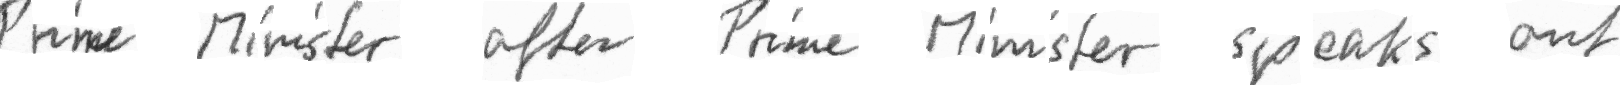

In [52]:
gg

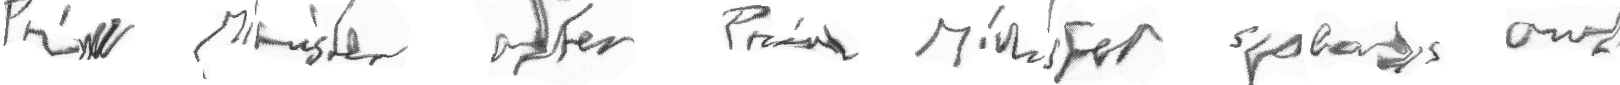

In [42]:
gg

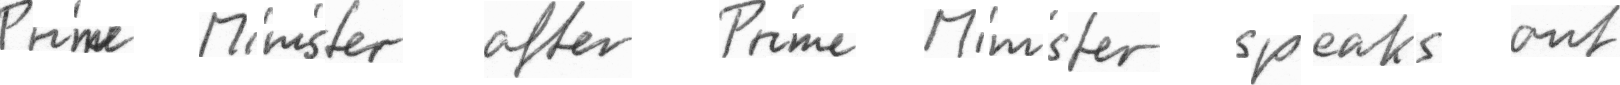

In [38]:
im

In [70]:
img = pp.preprocess("../raw/iam/lines/b01/b01-000/b01-000-00.png", input_size=(1024,128,1))

In [67]:
def pre(path, input_size):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    wt, ht, _ = input_size
    h, w = img.shape
    f = max((w / wt), (h / ht))
    new_size = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1))

    img = cv2.resize(img, new_size)
    img = pp.illumination_compensation(img)
    img = pp.remove_cursive_style(img)
    img = cv2.resize(img, new_size)
    target = np.ones([ht, wt], dtype=np.uint8) * 255
    target[0:new_size[1], 0:new_size[0]] = img
    return target

In [68]:
img = pre("../raw/iam/lines/b01/b01-000/b01-000-00.png", input_size=(1024,128,1))

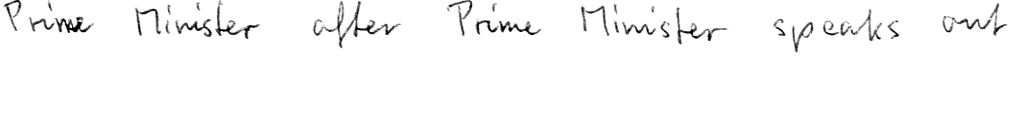

In [73]:
Image.fromarray(cv2.transpose(img))

In [ ]:
cv2.transpose(img)

In [13]:
import json
# with open("pre.json","w") as f:
#     json.dump(less+ more, f)
    
with open("pre.json","r") as f:
    a= json.load(f)

In [77]:
1542//2

771

In [14]:
less = a[:771]

In [14]:
more = a[771:]

In [37]:
source = "../data/rimes.hdf5"
split = "train"

In [38]:
dataset = dict()

with h5py.File(source, "r") as f:
    dataset[split] = dict()

    dataset[split]['dt'] = np.array(f[split]['dt'])
    dataset[split]['gt'] = np.array(f[split]['gt'])

    randomize = np.arange(len(dataset[split]['gt']))
    np.random.seed(42)
    np.random.shuffle(randomize)

    dataset[split]['dt'] = dataset[split]['dt'][randomize]
    dataset[split]['gt'] = dataset[split]['gt'][randomize]

    # decode sentences from byte
    dataset[split]['gt'] = [x.decode() for x in dataset[split]['gt']]


In [41]:
len(dataset[split]['dt'])

10114

In [22]:
from PIL import Image

In [41]:
for i,v in enumerate(dataset[split]['gt']):
    if "ne quantite importante de" in unicodedata.normalize("NFKD", v).encode("ASCII", "ignore").decode("ASCII"):
        print(i)
#     Image.fromarray(cv2.transpose(dataset["test"]["dt"][1]))

761


In [48]:
gt[769], predicts[769]

('le revenu . Je souhaite , a partir de ce jour , opter pour',
 'le revenu . Je souhaite , a partir de ce jour , opter pour')

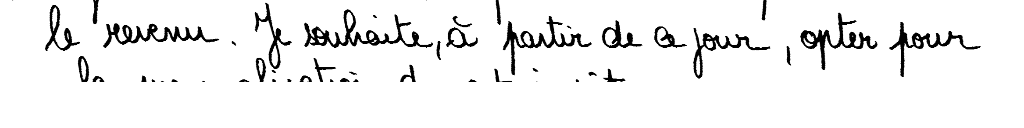

In [46]:
Image.fromarray(cv2.transpose(dataset["test"]["dt"][769]))

In [39]:
tokenizer.encode('ai réglé régulièrement les intérêts .')

array([ 2, 14, 22, 98, 31, 18, 20, 25, 18, 98, 31, 18, 20, 34, 25, 22, 18,
       31, 18, 26, 18, 27, 33, 98, 25, 18, 32, 98, 22, 27, 33, 18, 31, 18,
       33, 32, 98, 79,  3])

In [40]:
tokenizer.decode([ 2, 14, 22, 98, 31, 18, 20, 25, 18, 98, 31, 18, 20, 34, 25, 22, 18,
       31, 18, 26, 18, 27, 33, 98, 25, 18, 32, 98, 22, 27, 33, 18, 31, 18,
       33, 32, 98, 79,  3])

'SOSai regle regulierement les interets . EOS'

In [69]:
img = cv2.imread("../raw/iam/lines/b01/b01-000/b01-000-00.png")

In [70]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [65]:
img.shape, gray.shape

((140, 1856, 3), (140, 1856))

In [58]:
im = pp.preprocess("../raw/iam/lines/a04/a04-000/a04-000-00.png", (1024, 128, 1))

In [71]:
imm = pp.remove_cursive_style(gray)

In [72]:
cv2.imwrite("temp.png",imm)

True

In [54]:
im.shape

(1024, 128)

In [1]:
import timm


In [1]:
from torchvision.models import resnet50, resnet34, resnet18

In [2]:
resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/mhamdan/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
import timm 

In [17]:
a = timm.create_model('resnest101e', pretrained=True,)

In [18]:
for n,p in a.named_parameters():
    print(n)

conv1.0.weight
conv1.1.weight
conv1.1.bias
conv1.3.weight
conv1.4.weight
conv1.4.bias
conv1.6.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.conv.weight
layer1.0.conv2.bn0.weight
layer1.0.conv2.bn0.bias
layer1.0.conv2.fc1.weight
layer1.0.conv2.fc1.bias
layer1.0.conv2.bn1.weight
layer1.0.conv2.bn1.bias
layer1.0.conv2.fc2.weight
layer1.0.conv2.fc2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.1.weight
layer1.0.downsample.2.weight
layer1.0.downsample.2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.conv.weight
layer1.1.conv2.bn0.weight
layer1.1.conv2.bn0.bias
layer1.1.conv2.fc1.weight
layer1.1.conv2.fc1.bias
layer1.1.conv2.bn1.weight
layer1.1.conv2.bn1.bias
layer1.1.conv2.fc2.weight
layer1.1.conv2.fc2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.conv.weight
layer1.2.conv